
Processing file: Cp_ts_RAH06_deg000.mat
File parts: ['Cp', 'ts', 'RAH06', 'deg000.mat']
Contents of Cp_ts_RAH06_deg000.mat: dict_keys(['__header__', '__version__', '__globals__', 'Building_height', 'Roof_pitch', 'Building_depth', 'Building_breadth', 'Eave_type', 'Wind_azimuth', 'Wind_pressure_coefficients', 'Location_of_measured_points', 'readme', 'Roof_type', 'Sample_frequency', 'Sample_period'])
Cp shape: (14063, 208)
Success - Roof type: A, Height-Width Ratio: 0.25, Degree: 0

Processing file: Cp_ts_RAH06_deg023.mat
File parts: ['Cp', 'ts', 'RAH06', 'deg023.mat']
Contents of Cp_ts_RAH06_deg023.mat: dict_keys(['__header__', '__version__', '__globals__', 'Building_height', 'Roof_pitch', 'Building_depth', 'Building_breadth', 'Eave_type', 'Wind_azimuth', 'Wind_pressure_coefficients', 'Location_of_measured_points', 'readme', 'Roof_type', 'Sample_frequency', 'Sample_period'])
Cp shape: (14063, 208)
Success - Roof type: A, Height-Width Ratio: 0.25, Degree: 23

Processing file: Cp_ts_RAH06

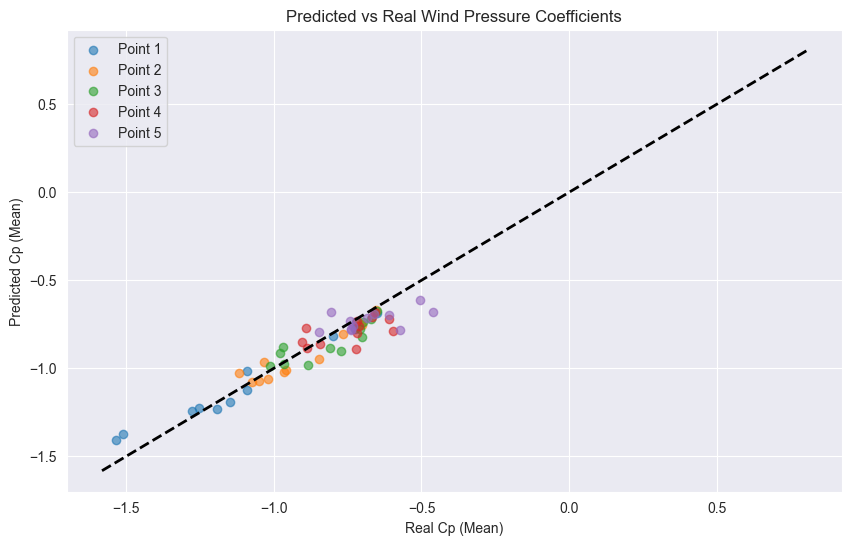

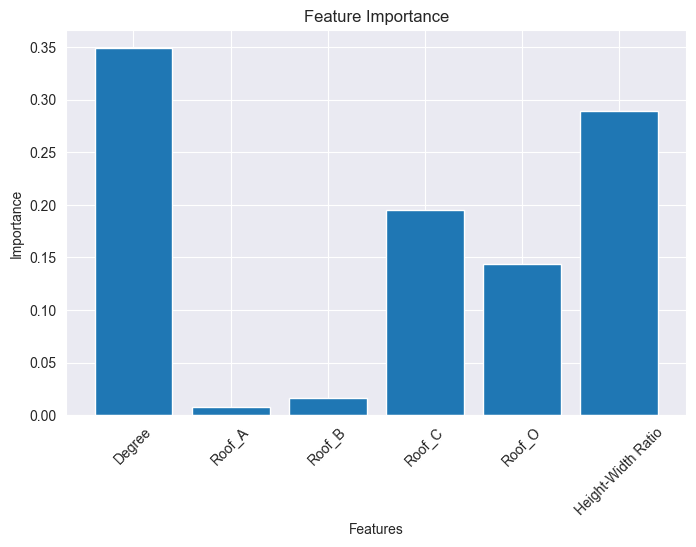

In [3]:
import numpy as np
import os
import scipy.io as sio
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Specify the directory
directory = r"../data/DATAAIO"

# Initialize lists to store data
roof_types = []
degrees = []
height_width_ratios = []
Cp_real = []

# Height-width ratio mapping
hw_ratio_map = {'18': 0.75, '12': 0.5, '06': 0.25}

# Roof type mapping
roof_type_map = {'OH': 'O', 'AH': 'A', 'BH': 'B', 'CH': 'C'}

# Load data
files = os.listdir(directory)
for file in files:
    if file.endswith('.mat'):
        print(f"\nProcessing file: {file}")
        try:
            parts = file.split('_')
            print(f"File parts: {parts}")
            if len(parts) >= 3 and parts[0] == 'Cp' and parts[1] == 'ts':
                roof_part = parts[2]
                if len(roof_part) >= 5 and roof_part.startswith('R'):
                    roof_code = roof_part[1:3]
                    ratio_code = roof_part[3:5]
                    if roof_code in roof_type_map:
                        roof_type = roof_type_map[roof_code]
                    else:
                        print(f"Skipping file {file} due to unrecognized roof type code: {roof_code}")
                        continue
                    if ratio_code in hw_ratio_map:
                        height_width_ratio = hw_ratio_map[ratio_code]
                    else:
                        print(f"Skipping file {file} due to unrecognized height-width ratio code: {ratio_code}")
                        continue
                    degree_part = parts[3].replace('.mat', '')
                    if degree_part.startswith('deg'):
                        degree_str = degree_part[3:]
                        if degree_str.isdigit():
                            degree = int(degree_str)
                        else:
                            print(f"Skipping file {file} due to invalid degree value: {degree_str}")
                            continue
                    else:
                        print(f"Skipping file {file} due to invalid degree format: {degree_part}")
                        continue

                    data = sio.loadmat(os.path.join(directory, file))
                    print(f"Contents of {file}: {data.keys()}")
                    if 'Wind_pressure_coefficients' in data:
                        Cp = data['Wind_pressure_coefficients']
                        print(f"Cp shape: {Cp.shape}")
                        if Cp.size > 0:
                            Cp_real.append(Cp)
                            roof_types.append(roof_type)
                            degrees.append(degree)
                            height_width_ratios.append(height_width_ratio)
                            print(f"Success - Roof type: {roof_type}, Height-Width Ratio: {height_width_ratio}, Degree: {degree}")
                        else:
                            print(f"Skipping file {file} due to empty 'Wind_pressure_coefficients' data.")
                    else:
                        print(f"Skipping file {file} due to missing 'Wind_pressure_coefficients' data.")
                else:
                    print(f"Skipping file {file} due to invalid roof/height-width part: {roof_part}")
            else:
                print(f"Skipping file {file} due to unexpected filename format.")
        except Exception as e:
            print(f"Skipping file {file} due to error: {e}")

# Convert metadata to numpy arrays
roof_types = np.array(roof_types)
degrees = np.array(degrees)
height_width_ratios = np.array(height_width_ratios)

# Pad Cp_real to max second dimension
max_points = max(cp.shape[1] for cp in Cp_real)
print(f"\nPadding Cp_real to max second dimension: {max_points}")
Cp_padded = [np.pad(cp, ((0, 0), (0, max_points - cp.shape[1])), mode='constant', constant_values=0)
             if cp.shape[1] < max_points else cp for cp in Cp_real]
Cp_real = np.stack(Cp_padded)
print(f"Cp_real shape: {Cp_real.shape}")

# Prepare target: mean Cp across time (axis 1)
y = np.mean(Cp_real, axis=1) # Shape: (60, 348)
print(f"Target (y) shape: {y.shape}")

# Prepare features (X)
encoder = OneHotEncoder(sparse_output=False)
roof_types_encoded = encoder.fit_transform(roof_types.reshape(-1, 1))
X = np.hstack([degrees.reshape(-1, 1), roof_types_encoded, height_width_ratios.reshape(-1, 1)])
print(f"Features (X) shape: {X.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
mae = mean_absolute_error(y_test, y_pred)
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Plot Predicted vs Real (for a few points)
n_points_to_plot = 5 # Plot first 5 points for clarity
plt.figure(figsize=(10, 6))
for i in range(n_points_to_plot):
    plt.scatter(y_test[:, i], y_pred[:, i], label=f'Point {i+1}', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Real Cp (Mean)')
plt.ylabel('Predicted Cp (Mean)')
plt.title('Predicted vs Real Wind Pressure Coefficients')
plt.legend()
plt.grid(True)
plt.show()

# Feature importance
feature_names = ['Degree'] + [f'Roof_{cat}' for cat in encoder.categories_[0]] + ['Height-Width Ratio']
importances = model.feature_importances_
plt.figure(figsize=(8, 5))
plt.bar(feature_names, importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()